# Linear Regression - Sampling

Implementation of a linear regression model. Weights are estimated with Monte Carlo Markov Chain (MCMC) sampling using [PyTorch distributions](https://pytorch.org/docs/stable/distributions.html) & [Pyro](http://pyro.ai/). 

$y \sim \mathcal{N}(\alpha x + \beta, \sigma)$


## Setting up the environment

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Define model

In [3]:
def linear_model(x_obs, y_obs):
    α = pyro.sample('α', dist.Normal(0., 10.))
    β = pyro.sample('β', dist.Normal(0., 10.))
    σ = pyro.sample('σ', dist.Uniform(0., 10.))
    m = α * x_obs + β
    with pyro.plate('data', len(x_obs)):
        pyro.sample('obs', dist.Normal(m, σ), obs=y_obs)

## Generate dataset

In [4]:
α_actual = 2.6
β_actual = 3.3
σ_actual = 0.7

In [5]:
def generate_samples(α, β, σ, min_x=-1, max_x=1, n_samples=500):
    x = np.linspace(min_x, max_x, n_samples)[:, np.newaxis]
    y = α * x + β
    dist = torch.distributions.Normal(torch.from_numpy(y), σ)
    return x, y, dist.sample().detach().numpy()

In [6]:
def plot_line(x, y, y_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=3)
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], alpha=0.8)
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    return ax

In [7]:
x, y, y_sample = generate_samples(α_actual, β_actual, σ_actual)

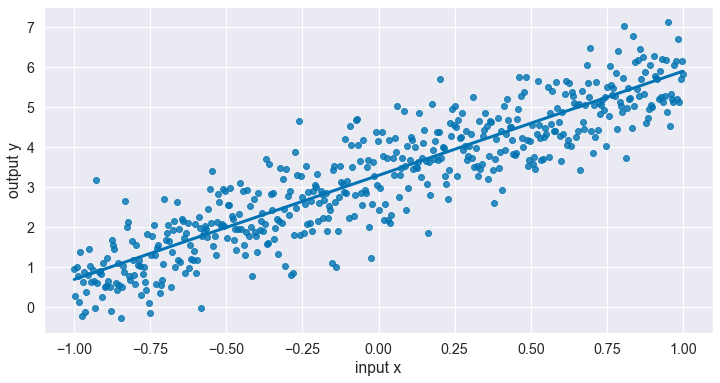

In [8]:
plot_line(x, y, y_sample);

In [9]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [10]:
x_train, x_test, y_train, y_test = compute_train_test_split(x, y_sample, test_size=0.2)

In [11]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

## Sample

In [12]:
nuts_kernel = NUTS(linear_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=2000)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 4000/4000 [01:25, 46.89it/s, step size=5.40e-01, acc. prob=0.915]


In [13]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [14]:
res = summary(hmc_samples)
for site, values in res.items():
    print(site)
    print(values, "\n")

α
       mean       std       5%       25%       50%       75%       95%
0  2.577201  0.002842  2.57246  2.575314  2.577224  2.579093  2.581918 

β
       mean       std        5%       25%       50%       75%       95%
0  3.232284  0.001714  3.229532  3.231135  3.232261  3.233455  3.235203 

σ
       mean       std        5%       25%       50%       75%       95%
0  0.693435  0.001267  0.691422  0.692532  0.693427  0.694282  0.695575 



In [15]:
def plot_parameter_distributions(hmc_samples, res):
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()
    
    for i, (site, _) in enumerate(res.items()):
        ax = axes[i]
        ax.set_title(f'{site}')
        sns.distplot(hmc_samples[site], ax=ax)

/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

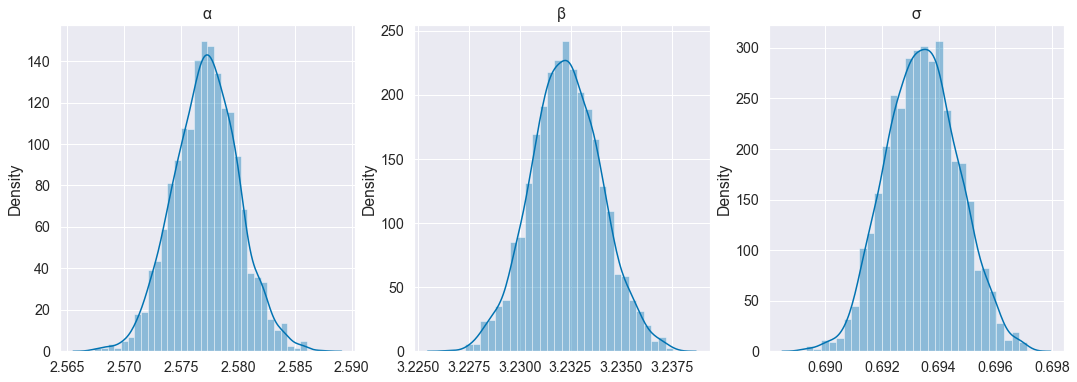

In [16]:
plot_parameter_distributions(hmc_samples, res)

## Results

In [17]:
def compute_rmse(y_actual, y_prediction):
    return torch.sqrt(torch.mean((y_actual - y_prediction)**2))

In [18]:
α_hat = res['α']['mean'].iloc[0]
β_hat = res['β']['mean'].iloc[0]
σ_hat = res['σ']['mean'].iloc[0]

print(f'Actual α = {α_actual:.2f} | Predicted α = {α_hat:.2f}')
print(f'Actual β = {β_actual:.2f} | Predicted β = {β_hat:.2f}')
print(f'Actual σ = {σ_actual:.2f} | Predicted σ = {σ_hat:.2f}')

Actual α = 2.60 | Predicted α = 2.58
Actual β = 3.30 | Predicted β = 3.23
Actual σ = 0.70 | Predicted σ = 0.69


In [19]:
def predict(a, b, s, x):
    return torch.distributions.Normal(a * x + b, s).sample()

In [20]:
y_hat = predict(α_hat, β_hat, σ_hat, x_test)

In [21]:
val_rmse = float(compute_rmse(y_test, y_hat).detach().numpy())
print(f'Validation RMSE = {val_rmse}')

Validation RMSE = 0.8888827354133352


In [22]:
def plot_results(x, y, y_sample, y_pred, y_pred_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=2, label='Actual line')
    ax.plot(x.flatten(), y_pred.flatten(), '-', color=palette[1], linewidth=2, label='Predicted line')
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], label='Actual samples')
    ax.scatter(x.flatten(), y_pred_sample.flatten(), color=palette[1], label='Predicted samples')
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

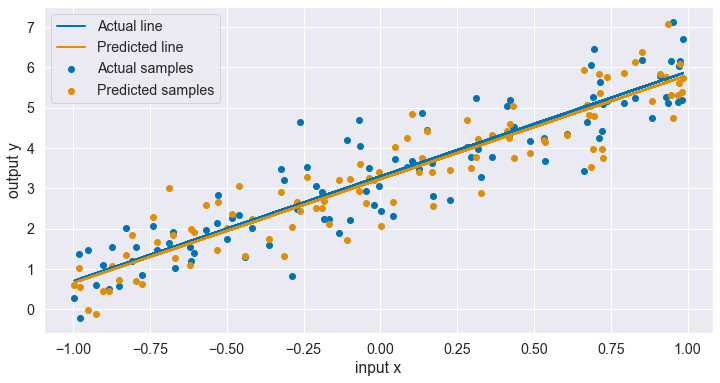

In [23]:
plot_results(
    x_test.detach().numpy(), 
    α_actual * x_test.detach().numpy() + β_actual, 
    y_test.detach().numpy(), 
    α_hat * x_test.detach().numpy() + β_hat, 
    y_hat.detach().numpy()
);